<a href="https://colab.research.google.com/github/jacob-torres/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Jacob_Torres_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [192]:
%%capture
import sys
import warnings
warnings.filterwarnings('ignore')

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [210]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders.ordinal import OrdinalEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [194]:
print(train.shape)
train.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Splitting the Data

In [195]:
# Feature and target matrices
train.drop('date_recorded', axis=1, inplace=True)
features = train.columns[:-1]
target = ['status_group']

X = train[features]
y = np.ravel(train[target])

print(f"""
Features: {X.shape}
Target: {y.shape}
""")


Features: (59400, 39)
Target: (59400,)



In [196]:
# Split for training and validation
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=122995
)

In [197]:
# Build a model pipeline
encoder = OrdinalEncoder(handle_unknown=True)
scaler = StandardScaler()
imputer = SimpleImputer()
classifier = RandomForestClassifier()
    
model = make_pipeline(
    encoder, scaler, imputer, classifier
)

In [198]:
# Score the model
model.fit(X_train, y_train)

print(f"The average accuracy score for the model = {model.score(X_val, y_val)}")

The average accuracy score for the model = 0.8131313131313131


## Tune the Hyperparameters

In [199]:
hyperparams = {
    'randomforestclassifier__n_estimators': [100, 500],
    'randomforestclassifier__max_depth': [None, 5, 15],
    'randomforestclassifier__n_jobs': [None, -1]
}
  
#search_cv = RandomizedSearchCV(model, hyperparams)
#search_cv.fit(X_train, y_train)

In [200]:
# Use optimized hyperparameters
classifier = RandomForestClassifier(
    n_estimators=500, n_jobs=-1
)
model.fit(X_train, y_train)

print(f"The tuned accuracy score of the model = {model.score(X_val, y_val)}")

The tuned accuracy score of the model = 0.8115319865319865


In [205]:
# Drop redundent features
X = train.drop(
    columns=[
             'id', 'funder', 'installer', 'region',
             'public_meeting', 'recorded_by', 'scheme_management',
             'extraction_type_class', 'extraction_type_group', 'management', 'payment_type',
             'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group', 'status_group'
    ]
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=122995
)

In [207]:
model = make_pipeline(
    OrdinalEncoder(), StandardScaler(),
    SimpleImputer(), RandomForestClassifier(n_estimators=500, n_jobs=-1)
)

In [209]:
model.fit(X_train, y_train)

print(f"The accuracy of the new model = {model.score(X_val, y_val)}")

The accuracy of the new model = 0.8088383838383838


## Confusion Matrix

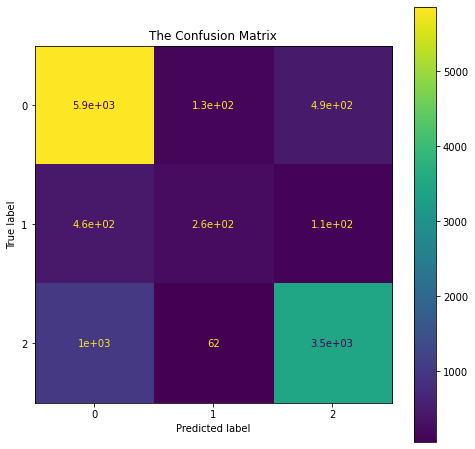

In [211]:
# Create plot
plt.style.use("seaborn-bright")
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("The Confusion Matrix")
plot_confusion_matrix(model, X_val, y_val, ax=ax)
plt.show()
